In [1]:
import diffxpy.api as de
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_groupies as npg
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
import seaborn
import matplotlib as mpl
import gget

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

2022-08-30 12:57:39.966142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib:/usr/local/lib64:/usr/lib64
2022-08-30 12:57:39.966200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

# Oligos

In [4]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    
    selected_cells = []
    for c in np.unique(labels):
        ix = np.where(labels == c)[0]
        ix = np.random.choice(ix, 25000, replace=False)
        selected_cells.append(ix)
    selected_cells = np.sort(np.hstack(selected_cells))
    
    # get data
    totals = ds.ca.TotalUMI[selected_cells]
    X = ds[:, selected_cells] / totals * np.median(totals)
    labels = labels[selected_cells] 

np.unique(labels)

array([0, 1])

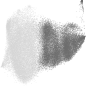

In [6]:
plt.figure(None, (1.5, 1.5))

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:

    colors = np.array(['dimgray' if l == 0 else 'lightgray' for l in labels])
    
    plt.scatter(ds.ca.TSNE[selected_cells, 0], ds.ca.TSNE[selected_cells, 1], c=colors, s=0.3, lw=0, alpha=0.5, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.tight_layout()

In [7]:
%%time

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:
    
    results = de.test.pairwise(
        data=X.T,
        grouping=labels,
        test='rank',
        lazy=False,
        gene_names=ds.ra.Gene,
        noise_model=None,
        sample_description=ds.ca.CellID[selected_cells],
        is_logged=False,
        pval_correction='by_test'
    )


INFO:diffxpy:additional kwargs: {'is_logged': False}


Sat Jul 16 13:37:28 2022 INFO additional kwargs: {'is_logged': False}


CPU times: user 14min 31s, sys: 49.7 s, total: 15min 21s
Wall time: 15min 21s


In [5]:
de_table = pd.read_csv('de_oligo.csv').query('qval < 1e-5')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,SLC27A6,0.000000e+00,0.000000e+00,-2.540213,0.063500
1,1,LINC02823,2.720068e-86,2.457672e-85,-5.620685,0.005921
2,2,PDE4B-AS1,1.873371e-31,7.772124e-31,0.018891,0.048131
3,3,MDFIC2,1.063213e-79,8.789444e-79,-1.086858,0.035417
4,4,AL591115.1,1.282581e-190,3.069656e-189,-2.785818,0.115009


<AxesSubplot:>

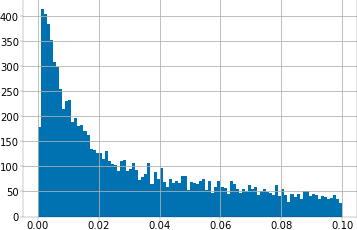

In [6]:
de_table['mean'].hist(bins=100, range=(0, 0.1))

In [7]:
de_table = pd.read_csv('de_oligo.csv').query('qval < 1e-5 & mean > 0.02')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,SLC27A6,0.000000e+00,0.000000e+00,-2.540213,0.063500
2,2,PDE4B-AS1,1.873371e-31,7.772124e-31,0.018891,0.048131
3,3,MDFIC2,1.063213e-79,8.789444e-79,-1.086858,0.035417
4,4,AL591115.1,1.282581e-190,3.069656e-189,-2.785818,0.115009
6,6,AL118556.2,1.475800e-63,9.927775e-63,-0.393299,0.040170


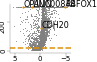

In [45]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = de_table['log2fc']
y = np.copy(de_table['qval'])
# setting to less than 1e-300 makes np.log10 inf
y[y == 0] = 1e-300
y = -np.log10(y)
ax.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
ax.hlines(-np.log10(1e-20), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['RBFOX1', 'OPALIN', 'CDH20', 'LINC00844']:
    ix = de_table['gene'] == g
    ax.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    ax.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
ax.invert_xaxis()
plt.savefig('/home/kimberly/figures/figure5/volcano_oligo.pdf', dpi=300)

In [47]:
(-x < 0).sum(), (-x > 0).sum()

(5128, 6174)

In [48]:
de_genes = de_table.query('log2fc < -1.5 | log2fc > 1.5')['gene'].to_list()
enr_table = gget.enrichr(de_genes, database="ontology")

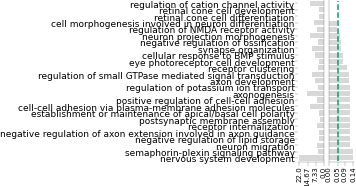

In [49]:
go_plot(enr_table)

In [50]:
enr_table.sort_values('adj_p_val')[:5]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,regulation of cation channel activity (GO:2001...,0.000002,6.349424,84.284382,"[MEF2C, NLGN1, GRIN2A, RELN, ACTN2, LRRC7, HPC...",0.003641,GO_Biological_Process_2021
1,2,retinal cone cell development (GO:0046549),0.000005,80.449485,980.493752,"[CRB2, USH1C, RORB, THY1]",0.003641,GO_Biological_Process_2021
2,3,retinal cone cell differentiation (GO:0042670),0.000005,80.449485,980.493752,"[CRB2, USH1C, RORB, THY1]",0.003641,GO_Biological_Process_2021
3,4,cell morphogenesis involved in neuron differen...,0.000097,5.441418,50.301622,"[MEF2C, DCC, PARD3, LRP4, SLITRK5, CCK, ANK3, ...",0.046909,GO_Biological_Process_2021
4,5,regulation of NMDA receptor activity (GO:2000310),0.000109,9.309603,84.912998,"[NLGN1, GRIN2A, MEF2C, RELN, ACTN2, LRRC7]",0.046909,GO_Biological_Process_2021


In [51]:
de_genes = de_table.query('log2fc > 2').sort_values('log2fc', ascending=False)
de_genes[:20]

,Unnamed: 0,gene,pval,qval,log2fc,mean
49,49,LAMA2,0.000000e+00,0.000000e+00,5.332120,1.027627
63,63,LINC00463,2.950431e-169,5.998791e-168,5.123192,0.027843
49486,49486,KCNAB1,0.000000e+00,0.000000e+00,4.675720,0.073559
64,64,PDGFD,7.316480e-69,5.280783e-68,4.654790,0.021218
43,43,FCHSD2,0.000000e+00,0.000000e+00,4.516573,1.876290
53194,53194,PLCL2,0.000000e+00,0.000000e+00,4.393258,0.226789
37,37,DYSF,0.000000e+00,0.000000e+00,4.355065,0.209879
49680,49680,LRP4-AS1,0.000000e+00,0.000000e+00,4.106835,0.076204
70,70,FRY,0.000000e+00,0.000000e+00,4.023402,0.270743
61,61,CRB2,0.000000e+00,0.000000e+00,3.993874,0.107321


In [52]:
de_genes.shape

(104, 6)

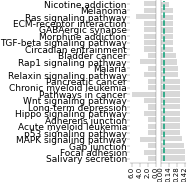

In [53]:
enr_table = gget.enrichr(de_genes['gene'].to_list(), database="pathway")  
go_plot(enr_table)

In [54]:
enr_table.sort_values('adj_p_val')[:10]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Nicotine addiction,0.001173,15.942467,107.577402,"[GABRB1, GRIN2A, GABRG3]",0.140808,KEGG_2021_Human
1,2,Melanoma,0.006282,8.535084,43.273457,"[CDH1, CDKN2A, PDGFD]",0.212232,KEGG_2021_Human
2,3,Ras signaling pathway,0.007305,4.376140,21.527386,"[GRIN2A, PDGFD, KIT, RASAL1, PAK5]",0.212232,KEGG_2021_Human
3,4,ECM-receptor interaction,0.010889,6.922889,31.291448,"[LAMA2, SV2B, FREM2]",0.212232,KEGG_2021_Human
4,5,GABAergic synapse,0.011227,6.842045,30.716895,"[GABRB1, SLC6A12, GABRG3]",0.212232,KEGG_2021_Human
5,6,Morphine addiction,0.011921,6.685869,29.614722,"[GABRB1, ARRB1, GABRG3]",0.212232,KEGG_2021_Human
6,7,TGF-beta signaling pathway,0.013007,6.464476,28.070241,"[ID3, LTBP1, TGFBR2]",0.212232,KEGG_2021_Human
7,8,Circadian entrainment,0.014149,6.257215,26.644006,"[GUCY1A2, GRIN2A, NOS1]",0.212232,KEGG_2021_Human
8,9,Bladder cancer,0.019248,9.983409,39.437998,"[CDH1, CDKN2A]",0.256639,KEGG_2021_Human
9,10,Rap1 signaling pathway,0.024067,3.823301,14.249064,"[GRIN2A, CDH1, PDGFD, KIT]",0.288808,KEGG_2021_Human


In [55]:
de_genes = de_table.query('log2fc < -2').sort_values('log2fc')
de_genes[:25]

,Unnamed: 0,gene,pval,qval,log2fc,mean
28,28,AC110809.1,0.000000e+00,0.000000e+00,-7.347785,0.093945
20,20,LINC02343,0.000000e+00,0.000000e+00,-6.964814,0.162021
24,24,ADAMTS12,0.000000e+00,0.000000e+00,-6.276746,0.089292
46040,46040,NKX2-8,0.000000e+00,0.000000e+00,-5.162496,0.023337
40774,40774,MBOAT1,0.000000e+00,0.000000e+00,-5.065342,0.287194
44239,44239,KANK4,0.000000e+00,0.000000e+00,-5.024256,0.199065
37611,37611,RBFOX1,0.000000e+00,0.000000e+00,-4.914575,4.783097
45105,45105,RAMP3,0.000000e+00,0.000000e+00,-4.627393,0.064421
40174,40174,AL122014.1,0.000000e+00,0.000000e+00,-4.613853,0.100713
40145,40145,CD44,0.000000e+00,0.000000e+00,-4.423328,0.034266


In [56]:
de_genes.shape

(164, 6)

In [29]:
enr_table = gget.enrichr(de_genes['gene'].to_list(), database="pathway")           

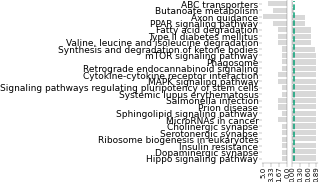

In [30]:
go_plot(enr_table)

In [31]:
enr_table.sort_values('adj_p_val')[:20]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,ABC transporters,0.000500,12.070122,91.750585,"[ABCC1, ABCC8, ABCA6, ABCA9]",0.041976,KEGG_2021_Human
1,2,Butanoate metabolism,0.001525,14.765963,95.764452,"[EHHADH, ACSM6, HMGCLL1]",0.064068,KEGG_2021_Human
2,3,Axon guidance,0.017221,3.492698,14.185966,"[SEMA5A, ABLIM3, SEMA4B, LIMK2, SEMA3A]",0.482173,KEGG_2021_Human
3,4,PPAR signaling pathway,0.022961,5.187210,19.576403,"[EHHADH, SLC27A6, ACSBG1]",0.482173,KEGG_2021_Human
4,5,Fatty acid degradation,0.048475,5.960554,18.040869,"[EHHADH, ACSBG1]",0.707774,KEGG_2021_Human
5,6,Type II diabetes mellitus,0.054690,5.553311,16.138314,"[ABCC8, CACNA1B]",0.707774,KEGG_2021_Human
6,7,"Valine, leucine and isoleucine degradation",0.058981,5.311326,15.033907,"[EHHADH, HMGCLL1]",0.707774,KEGG_2021_Human
7,8,Synthesis and degradation of ketone bodies,0.079056,13.515337,34.296458,[HMGCLL1],0.830091,KEGG_2021_Human
61,62,mTOR signaling pathway,0.719981,0.789246,0.259291,[RNF152],0.894229,KEGG_2021_Human
60,61,Phagosome,0.715295,0.799781,0.267974,[TUBB2B],0.894229,KEGG_2021_Human


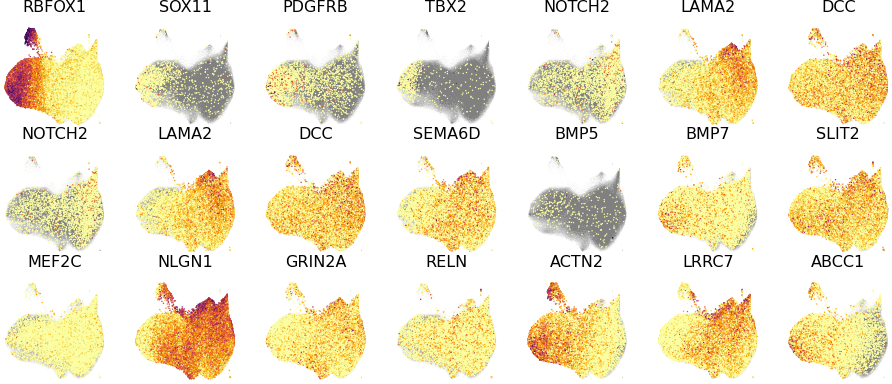

In [95]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:
  
    plt.figure(None, (8, 8), dpi=144, facecolor='white')
    gs = plt.GridSpec(7, 7)

    to_plot = ['RBFOX1', 'SOX11', 'PDGFRB', 'TBX2', 'NOTCH2', 'LAMA2', 'DCC',
              'NOTCH2', 'LAMA2', 'DCC', 'SEMA6D', 'BMP5', 'BMP7', 'SLIT2',
               'MEF2C', 'NLGN1', 'GRIN2A', 'RELN', 'ACTN2', 'LRRC7', 'ABCC1']

    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.UMAP[:, 0], ds.ca.UMAP[:, 1], color='grey', alpha=0.01, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=exp[cells], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        plt.title(g, fontsize=8)
        plt.margins(0.05, 0.05)

    plt.show()

# OPCs

In [27]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    
    selected_cells = []
    for c in np.unique(labels):
        ix = np.where(labels == c)[0]
        ix = np.random.choice(ix, 25000, replace=False)
        selected_cells.append(ix)
    selected_cells = np.sort(np.hstack(selected_cells))
    
    # get data
    totals = ds.ca.TotalUMI[selected_cells]
    X = ds[:, selected_cells] / totals * np.median(totals)
    labels = labels[selected_cells] 

np.unique(labels)

array([0, 1])

In [28]:
%%time

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
    
    results = de.test.pairwise(
        data=X.T,
        grouping=labels,
        test='rank',
        lazy=False,
        gene_names=ds.ra.Gene,
        noise_model=None,
        sample_description=ds.ca.CellID[selected_cells],
        is_logged=False,
        pval_correction='by_test'
    )


INFO:diffxpy:additional kwargs: {'is_logged': False}


Fri Jul 15 20:52:28 2022 INFO additional kwargs: {'is_logged': False}


CPU times: user 15min 13s, sys: 51.1 s, total: 16min 5s
Wall time: 16min 4s


In [109]:
de_table = pd.read_csv('de_opc.csv').query('qval < 1e-5')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,HES5,0.000000e+00,0.000000e+00,-2.962547,0.333586
1,1,GPC5,0.000000e+00,0.000000e+00,-3.448639,2.135822
2,2,ZNF736P9Y,1.943288e-299,3.174928e-297,-7.386404,0.033742
3,3,APOE,0.000000e+00,0.000000e+00,-1.752303,0.206426
4,4,LRRC3B,0.000000e+00,0.000000e+00,-3.404837,0.206313


In [110]:
de_table.shape

(9719, 6)

<AxesSubplot:>

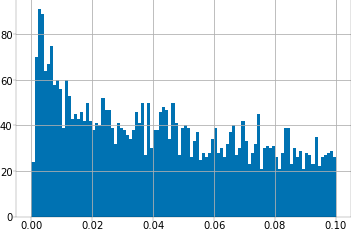

In [58]:
de_table['mean'].hist(bins=100, range=(0, 0.1))

In [141]:
de_table = pd.read_csv('de_opc.csv').query('qval < 1e-5 & mean > 0.02')

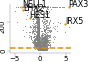

In [81]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = de_table['log2fc']
y = np.copy(de_table['qval'])
# setting to less than 1e-300 makes np.log10 inf
y[y == 0] = 1e-300
y = -np.log10(y)
plt.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
plt.hlines(-np.log10(1e-20), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
    ix = de_table['gene'] == g
    plt.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    plt.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
plt.savefig('/home/kimberly/figures/figure5/volcano_opcs.pdf', dpi=300)

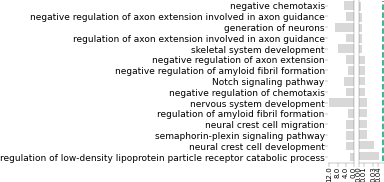

In [146]:
de_genes = de_table.query('log2fc < -1.58 | log2fc > 1.58')['gene'].to_list()
enr_table = gget.enrichr(de_genes, database="ontology")
go_plot(enr_table, 15, '/home/kimberly/figures/figure5/opc_type_GO.pdf')

In [147]:
np.log2(3)

1.584962500721156

In [148]:
len(de_genes)

155

In [149]:
enr_table.query('adj_p_val <= 0.05').sort_values('rank')

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,negative chemotaxis (GO:0050919),0.000005,23.591667,286.946959,"[SEMA3D, SEMA3A, SEMA6D, SLIT1, SEMA3E]",0.005752,GO_Biological_Process_2021
1,2,negative regulation of axon extension involved...,0.000015,32.829470,364.082383,"[SEMA3D, SEMA6D, SEMA3A, SEMA3E]",0.007214,GO_Biological_Process_2021
2,3,generation of neurons (GO:0048699),0.000029,6.276812,65.612308,"[IRX1, IRX2, IRX5, LHX2, SEMA3A, CCK, HES1, FG...",0.007214,GO_Biological_Process_2021
3,4,regulation of axon extension involved in axon ...,0.000033,26.258278,271.218891,"[SEMA3D, SEMA6D, SEMA3A, SEMA3E]",0.007214,GO_Biological_Process_2021
4,5,skeletal system development (GO:0001501),0.000033,7.145578,73.793791,"[NCAN, TNFRSF11B, PRELP, HOXD3, BMPR1B, PAPSS2...",0.007214,GO_Biological_Process_2021
5,6,negative regulation of axon extension (GO:0030...,0.000093,19.443709,180.544845,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.012902,GO_Biological_Process_2021
6,7,negative regulation of amyloid fibril formatio...,0.000095,43.500000,402.692325,"[APOE, CRYAB, LDLR]",0.012902,GO_Biological_Process_2021
7,8,Notch signaling pathway (GO:0007219),0.000102,11.993939,110.288596,"[NRARP, HES1, MAML3, HOXD3, HES5]",0.012902,GO_Biological_Process_2021
8,9,negative regulation of chemotaxis (GO:0050922),0.000105,18.748344,171.697457,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.012902,GO_Biological_Process_2021
9,10,semaphorin-plexin signaling pathway (GO:0071526),0.000151,16.931425,149.002152,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.016535,GO_Biological_Process_2021


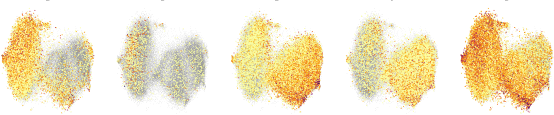

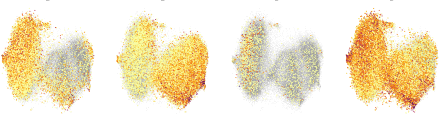

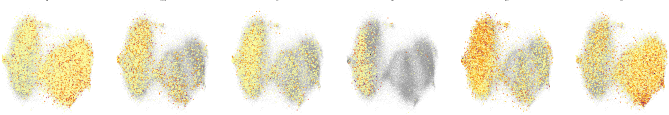

In [ ]:
for n in [0, 3, 4, 5, 7]:

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

        plt.figure(None, (12, 2))
        gs = plt.GridSpec(1, 6)

        to_plot = enr_table.loc[n, 'overlapping_genes'][:6]

        for i, g in enumerate(to_plot):
            plt.subplot(gs[i])
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            cells = exp > 0

            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

            plt.title(g, fontsize=0.5)
            plt.axis('off')
            plt.margins(0.02, 0.02)
        
        # plt.savefig(f'/home/kimberly/figures/figure5/opc_overlapping_genes_{n}.pdf', dpi=300)

In [122]:
de_genes = de_table.query('log2fc > 1.5').sort_values('log2fc', ascending=False)
de_genes[:20]

,Unnamed: 0,gene,pval,qval,log2fc,mean
36467,36467,HOXD-AS2,2.377800e-10,1.274411e-09,7.086680,0.001351
32818,32818,CCDC140,1.437362e-08,6.808457e-08,6.732896,0.000733
52973,52973,AL442644.1,1.489078e-06,6.100535e-06,6.374049,0.000435
35846,35846,HOXC4,3.948483e-22,3.862873e-21,6.258467,0.002820
36262,36262,VGLL2,1.438258e-08,6.811594e-08,5.959004,0.000894
34998,34998,HOXA-AS3,1.847910e-11,1.057478e-10,5.867329,0.001386
35710,35710,HOXB-AS3,9.750035e-39,1.645046e-37,5.850025,0.005571
34560,34560,HOXA3,6.538355e-98,2.832878e-96,5.647058,0.013535
33919,33919,HOXD3,1.012920e-167,7.697208e-166,5.562147,0.025966
21,21,PAX3,0.000000e+00,0.000000e+00,5.541471,0.312656


In [72]:
de_genes.shape

(94, 6)

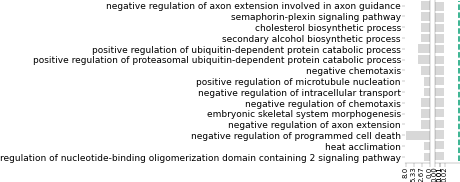

In [73]:
enr_table = gget.enrichr(de_genes['gene'].to_list(), database="ontology")
go_plot(enr_table, 15)

In [74]:
enr_table.sort_values('adj_p_val')[:20]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,negative regulation of axon extension involved...,0.000108,38.569489,352.213461,"[SEMA3D, SEMA3A, SEMA3E]",0.019251,GO_Biological_Process_2021
23,24,semaphorin-plexin signaling pathway (GO:0071526),0.000590,20.474588,152.234302,"[SEMA3D, SEMA3A, SEMA3E]",0.019251,GO_Biological_Process_2021
22,23,cholesterol biosynthetic process (GO:0006695),0.000590,20.474588,152.234302,"[INSIG1, MSMO1, DHCR24]",0.019251,GO_Biological_Process_2021
21,22,secondary alcohol biosynthetic process (GO:190...,0.000541,21.136122,158.975228,"[INSIG1, MSMO1, DHCR24]",0.019251,GO_Biological_Process_2021
20,21,positive regulation of ubiquitin-dependent pro...,0.000525,11.751704,88.747793,"[RNF144B, DAB2, HSPA1B, HSPA1A]",0.019251,GO_Biological_Process_2021
19,20,positive regulation of proteasomal ubiquitin-d...,0.000525,11.751704,88.747793,"[RNF144B, DAB2, HSPA1B, HSPA1A]",0.019251,GO_Biological_Process_2021
18,19,negative chemotaxis (GO:0050919),0.000495,21.841758,166.226033,"[SEMA3D, SEMA3A, SEMA3E]",0.019251,GO_Biological_Process_2021
17,18,positive regulation of microtubule nucleation ...,0.000452,86.526087,666.413957,"[HSPA1B, HSPA1A]",0.019251,GO_Biological_Process_2021
16,17,negative regulation of intracellular transport...,0.000452,86.526087,666.413957,"[INSIG1, CRYAB]",0.019251,GO_Biological_Process_2021
15,16,negative regulation of chemotaxis (GO:0050922),0.000452,22.596059,174.043443,"[SEMA3D, SEMA3A, SEMA3E]",0.019251,GO_Biological_Process_2021


In [75]:
de_genes = de_table.query('log2fc < -1.5').sort_values('log2fc')
de_genes[:25]

,Unnamed: 0,gene,pval,qval,log2fc,mean
2,2,ZNF736P9Y,1.943288e-299,3.174928e-297,-7.386404,0.033742
28618,28618,LINC02253,1.636441e-272,2.439790e-270,-4.827615,0.041085
10,10,FOXG1-AS1,0.000000e+00,0.000000e+00,-4.754678,0.056219
1699,1699,EMX2OS,4.728507e-202,4.555515e-200,-4.456663,0.023412
30514,30514,FOXG1,0.000000e+00,0.000000e+00,-4.421573,0.082653
30264,30264,LINC01551,0.000000e+00,0.000000e+00,-4.313300,0.044985
7,7,GPNMB,0.000000e+00,0.000000e+00,-3.982240,0.266481
27268,27268,AL049777.1,0.000000e+00,0.000000e+00,-3.901870,0.043731
17,17,LDB2,0.000000e+00,0.000000e+00,-3.535783,0.362037
14,14,NELL1,0.000000e+00,0.000000e+00,-3.503500,1.490419


In [76]:
de_genes.shape

(86, 6)

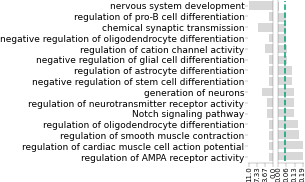

In [77]:
enr_table = gget.enrichr(de_genes['gene'].to_list(), database="ontology")
go_plot(enr_table, 15)

In [78]:
enr_table.sort_values('adj_p_val')[:20]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,nervous system development (GO:0007399),0.000003,6.552232,82.636941,"[CHRM3, NELL1, ADGRV1, NCAN, HES1, LDB2, RAPGE...",0.002096,GO_Biological_Process_2021
1,2,regulation of pro-B cell differentiation (GO:2...,0.000271,118.511905,973.352543,"[HES1, HES5]",0.059510,GO_Biological_Process_2021
2,3,chemical synaptic transmission (GO:0007268),0.000351,5.812836,46.246762,"[GRIA1, CHRM3, APOE, SYN3, CBLN2, SHISA6, NRGN]",0.059510,GO_Biological_Process_2021
3,4,negative regulation of oligodendrocyte differe...,0.000378,94.804762,747.009035,"[HES1, HES5]",0.059510,GO_Biological_Process_2021
4,5,regulation of cation channel activity (GO:2001...,0.000589,11.379627,84.630282,"[GRIA1, FGF13, CACNG3, SHISA6]",0.067632,GO_Biological_Process_2021
5,6,negative regulation of glial cell differentiat...,0.000645,67.710884,497.407188,"[HES1, HES5]",0.067632,GO_Biological_Process_2021
6,7,regulation of astrocyte differentiation (GO:00...,0.001173,47.390476,319.804985,"[HES1, HES5]",0.105391,GO_Biological_Process_2021
7,8,negative regulation of stem cell differentiati...,0.001382,43.080087,283.640874,"[HES1, HES5]",0.108680,GO_Biological_Process_2021
8,9,generation of neurons (GO:0048699),0.001797,6.178166,39.057653,"[LHX2, CCK, HES1, FGF13, HES5]",0.125559,GO_Biological_Process_2021
9,10,regulation of neurotransmitter receptor activi...,0.001997,13.050821,81.125420,"[GRIA1, CACNG3, SHISA6]",0.125610,GO_Biological_Process_2021


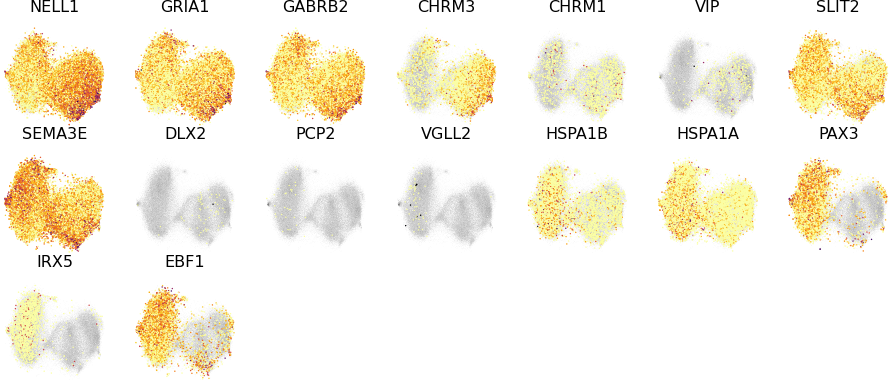

In [63]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
  
    plt.figure(None, (8, 8), dpi=144, facecolor='white')
    gs = plt.GridSpec(7, 7)

    to_plot = ['NELL1', 'GRIA1', 'GABRB2', 'CHRM3', 'CHRM1', 'VIP', 'SLIT2', 'SEMA3E', 'DLX2', 'PCP2', 'VGLL2',
              'HSPA1B', 'HSPA1A', 'PAX3', 'IRX5', 'EBF1']

    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        plt.title(g, fontsize=8)
        plt.margins(0.05, 0.05)

    plt.show()